• Edge Detection
• Image Gradient
• Canny-Edge Detector
• Feature Detection
• Moravec Corner Detector

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# load image
image  = cv2.imread('Image/city.jpg', 0)

# show image
# cv2.imshow('image', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [21]:
# reduce noise using gaussian filter
image_smooth = cv2.GaussianBlur(image, (3,3), 0)
# cv2.imshow('image', image_smooth )
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [19]:
# convert to grayscale needed if you use color image
# image_gray = cv2.cvtColor(image_smooth, cv2.COLOR_BGR2GRAY)


In [23]:
# create kernels for Sobel operation

sobel_x_kernel = np.array([[1,0,-1], [2,0,-2], [1,0,-1]]) # vertical(x filter)
sobel_y_kernel = sobel_x_kernel.T # horizontal (y filter)
# print(sobel_x_kernel, sobel_y_kernel)

In [24]:
# rotate kernels by 180 degrees for convolution
sobel_x_kernel = np.rot90(np.rot90(sobel_x_kernel))
sobel_y_kernel = np.rot90(np.rot90(sobel_y_kernel))

In [25]:
# filter with sobel operator
sobel_x_img = cv2.filter2D(image_smooth, -1, sobel_x_kernel)
sobel_y_img = cv2.filter2D(image_smooth, -1, sobel_y_kernel)

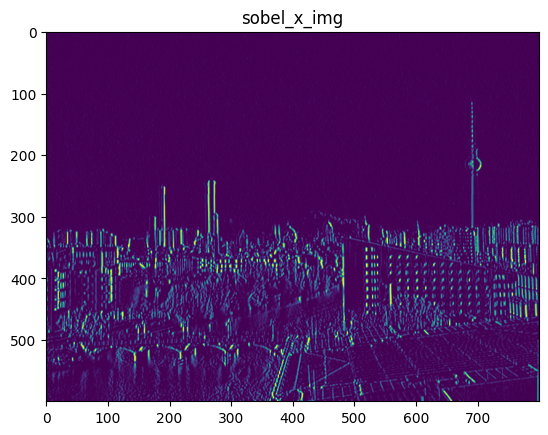

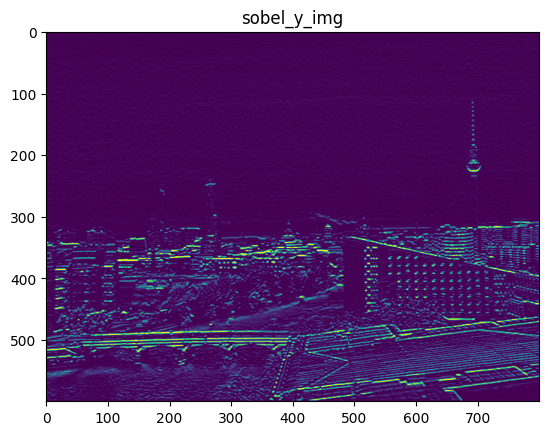

In [42]:
plt.title('sobel_x_img')
plt.imshow(sobel_x_img)
plt.show()

plt.title('sobel_y_img')
plt.imshow(sobel_y_img)
plt.show()

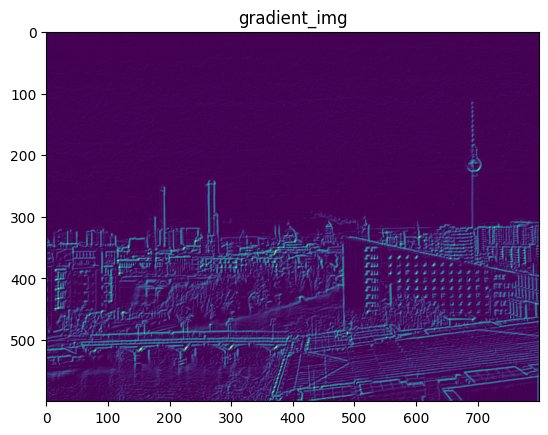

In [41]:
# create output image by blending both gradient images
# abs_sobel_x = cv2.convertScaleAbs(sobel_x_img)
# abs_sobel_y = cv2.convertScaleAbs(sobel_y_img)
gradient_img = cv2.addWeighted(sobel_x_img, 0.5, sobel_y_img, 0.5, 0)

plt.title('gradient_img')
plt.imshow(gradient_img)
plt.show()

In [39]:
# use opencv functions to create Sobel operators
sobel_X = cv2.Sobel(image_smooth, -1, 1, 0, ksize=3)
sobel_Y = cv2.Sobel(image_smooth, -1, 0, 1, ksize=3)
gradient_img_cv = cv2.addWeighted(sobel_X, 0.5, sobel_Y, 0.5, 0)

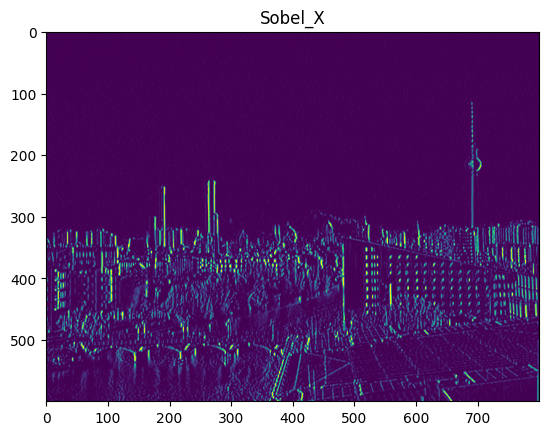

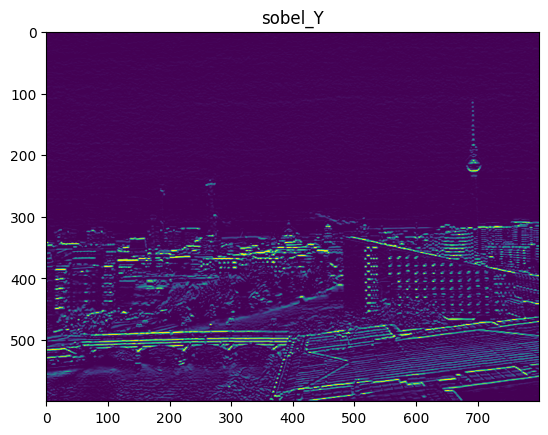

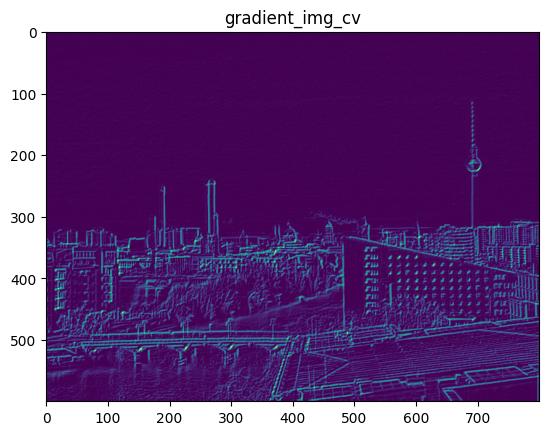

In [40]:
plt.title('Sobel_X')
plt.imshow(sobel_X)
plt.show()

plt.title('sobel_Y')
plt.imshow(sobel_Y)
plt.show()

plt.title('gradient_img_cv')
plt.imshow(gradient_img_cv)
plt.show()

Edge Detection
Objectives:
• Good detection: detect all edges as possible without too much clutter
• Good localization: minimum distance between detected and real edge
• Clear response: only one response per edge

Edge Detection
Canny Edge Detection Algorithm: 
- Reduction of noise by Gaussian filter
- Calculation of local gradient strength and direction
- Suppression of local non-maxima edge strengths
- Double Thresholding
- Edge Linking by Hysteresis

In [69]:
# load image
image = cv2.imread('Image/city.jpg')

# reduce noise
image_smooth = cv2.GaussianBlur(image, (3,3), 0)

# convert image BGR to gray
image_gray = cv2.cvtColor(image_smooth, cv2.COLOR_BGR2GRAY)


# Gradient calculation (strength and direction)
def gradient(image):

    # convert uint8 to float32
    image_32f = image.astype(np.float32)

    # create sobel filters
    sx = np.array([[-1,0,-1], [-2,0,2], [-1,0,1]])
    sy = sx.T

    # rotate the sobel operator for convolution
    sx = np.rot90(np.rot90(sx))
    sy = np.rot90(np.rot90(sy))

    # apply sobel filter to grayscale image
    image_x = cv2.filter2D(image_32f, -1, sx)
    image_y = cv2.filter2D(image_32f, -1, sy)

    # Calculate strength of edges (magniture G)
    G = np.hypot(image_x, image_y)

    # normalise mag image G = G/G.max() * 255
    cv2.normalize(G, G, 0, 255, cv2.NORM_MINMAX)
    G = G.astype(np.uint8)

    # calculate edge directions
    theta = np.arctan2(image_y, image_x) # in radians

    return (G, theta)
    

# Suppression of non-maximum edges: to thin out the edges
def non_max_suppression(image, direction_rad):
    height, width = image.shape
    image_maxima = np.zeros((height, width), image.dtype)

    # convert radian to degree
    # direction_deg = np.rad2deg(direction_rad)
    direction_deg = (direction_rad * 180. / np.pi) + 180

    # iterate over gradient direction
    for y in range(1, height-1):
        for x in range(1, width -1):

            # get edge strength of neighbouring pixel in horizontal direction:
            if ((0<= direction_deg[y,x] < 45) or (135 <= direction_deg[y,x] <225) or (direction_deg[y,x] >315 )):
                i = image[y, x+1]
                j = image[y, x-1]

            # get edge strength of neighbouring pixel in vertical direction:
            elif(45<= direction_deg[y,x] <135) or (225<direction_deg[y,x] <=315):
                i = image[y+1, x]
                j = image[y-1, x]

            # compare current edge pixel with neighboring edge pixels:
            if (image[y, x] < i) or (image[y,x]<j):
                image_maxima[y,x] = 0
            else:
                image_maxima[y,x]= image[y,x]
 
    return image_maxima


# Double thresholding to identify strong, weak and non-relevant edges
def double_threshold(image, lowThresholdRatio, highThresholdRatio, weakPixel, strongPixel):

    # calculate high and low threshold value
    high_threshold = image.max()*highThresholdRatio
    low_threshold = high_threshold * lowThresholdRatio
    print(lowThresholdRatio, highThresholdRatio)
    print(low_threshold, high_threshold)

    output = image.copy()

    # set all edge pixel to strong, if greater than or equal to high threshold
    output[output >= high_threshold] = strongPixel

    # set all edge pixel to weak, if they are between higher and lower threshold
    output[(output <high_threshold) & (output >= low_threshold)] = weakPixel

    # supress all edges below lower threshold
    output[output < low_threshold] = 0

    return output


In [70]:
G, theta = gradient(image_gray)
image_nonmax = non_max_suppression(image_gray, theta)

# set value for weak and strong pixel, low and high threshold
weak = 75
strong = 255
low = 0.05 # 0-1
high = 0.15 # 0-1

image_threshold = double_threshold(image_nonmax,low, high, weak, strong)

0.05 0.15
1.8 36.0


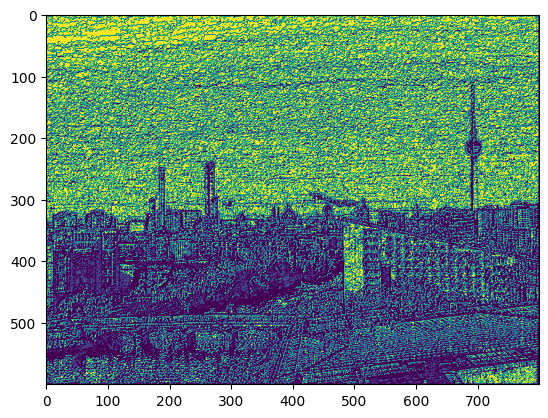

In [71]:
plt.imshow(image_threshold)

In [72]:
# Edge Linking by Hysteresis 

def hyteresis(image_threshold, weak, strong):
    img_hyt = image_threshold.copy()
    height, width = img_hyt.shape

    for y in range(1, height-1):
        for x in range(1, width-1):

            # check weak pixel:
            if img_hyt[y, x] < weak:
                img_hyt[y,x] =0

                # iterate over neighbouring pixel
                # if neighbour pixel is strong pixel set weak pixel to strong
                for k in range(-1,2):
                    for m in range(-1,2):
                        if (img_hyt[y+k, x+m]==strong):
                            img_hyt[y, x] = strong
    return img_hyt

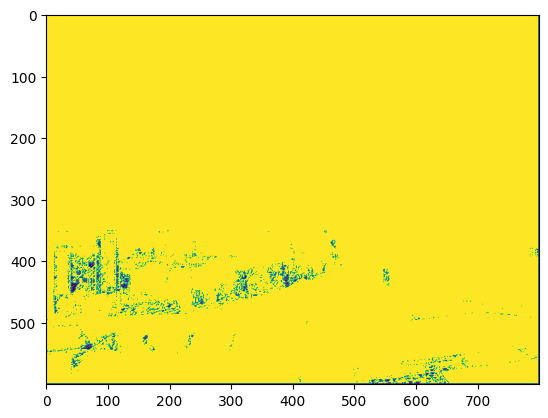

In [73]:
image_hyst = hyteresis(image_threshold, weak, strong)
plt.imshow(image_hyst)

In [81]:
# load image
img = cv2.imread('Image/city.jpg')

# noise reduction by gaussian filter of 3x3 kernel
img_smooth = cv2.GaussianBlur(img, (3,3), 0)

# covert to gray scale

img_gray = cv2.cvtColor(img_smooth, cv2.COLOR_BGR2GRAY)

# gradient calcualtion
G, theta = gradient(img_gray)

# non max suppression
nonMax_img = non_max_suppression(G, theta)

# set values for weak, strong pixel, high & low threshold
weak = 0
strong = 255
low = 0.05
high = 0.25

# double thresholding 
threshold_img = double_threshold(nonMax_img,low, high, weak, strong)

# edge linking by hysteresis
hysteresis_img = hyteresis(threshold_img, weak, strong)

# show the images
# cv2.imshow("Input image", img)
# cv2.imshow("1 - Gaussian smoothing", img_smooth)
# cv2.imshow("Input grayscale image", img_gray)
# cv2.imshow("2 - Gradient image)", G)
# cv2.imshow("3 - Non Maximum Suppression", nonMax_img)
# cv2.imshow("4 - Thresholding", threshold_img)
cv2.imshow("5 - Hysteresis", hysteresis_img)

""" Use Canny OpenCV """
canny = cv2.Canny(img, weak, strong)
cv2.imshow("Canny (OpenCV)", canny)

cv2.waitKey(0)
cv2.destroyAllWindows() 

0.05 0.25
3.1875 63.75


Feature Detection
Good local feature:
• has accurate and repeatable localization
• is invariant to translation, rotation, scale, viewpoint
• is robust against noise, lighting conditions, compression, blur,
• has a distinctive descriptor
• corner, blob (region of interest point)
Feature Detection:
• abstraction of image information
• making local decision at image points

Main Steps in Corner Detection:
1.measure cornerness of each pixel by corner operator
2.eliminate weak corners by thresholding
3.eliminate points with cornerness not larger than cornerness of
points in surrounding with a certain distance

In [88]:
# Morvac corner detector

# load image
img_1 = cv2.imread('Image/checker.jpg')

# smoothen the image
img = cv2.GaussianBlur(img_1, (3,3),1)

# convert to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# define map for shifts(u, v):
xy_shifts = [(1,0), (0,1), (-1,0), (0,-1), (1,1), (-1,-1), (-1,1), (1,-1)]

# threshold
threshold = 5

# iterate over image
for y in range(1, img.shape[0]-1): #height
    for x in range(1, img.shape[1]-1):  # width

        min = 1000000

        # iterate over neighbour pixel
        for shift in xy_shifts:
            # calculate square of difference between pixel and shift
            E = img[(y+shift[0], x+ shift[1])] - img[y,x] # difference in neighbour pixel
            E *= E  # sqaure of the difference
            if E < min:
                min = E
            
            if min > threshold:
                # draw circle on top of the input image
                cv2.circle(img_1, (x,y), 2,(0,0,255), -1)
                # print(x,y)


cv2.imshow("Morovec", img_1)
cv2.waitKey(0)
cv2.destroyAllWindows()


/tmp/ipykernel_5362/3005675097.py:27: RuntimeWarning: overflow encountered in ubyte_scalars
  E = img[(y+shift[0], x+ shift[1])] - img[y,x] # difference in neighbour pixel
/tmp/ipykernel_5362/3005675097.py:28: RuntimeWarning: overflow encountered in ubyte_scalars
  E *= E  # sqaure of the difference


Shortcomings:
- anisotropic response --> - gradients are only calculated for eight discrete shifts -directional sensitive (not invariant to rotation)
- noisy responses along an edge --> due to the binary window function
- responds too strong --> only local minimum of E(u,v) is taken for cornerness


- Solution: Harris Corner Detector
(C. Harris and M. Stephens, "A Combined Corner and Edge Detector.", 1988)